In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# CGS constants
G = 6.67430e-8
M_sun = 1.98847e33
R_earth = 6.371e8

df = pd.read_csv("../data/white_dwarf_data.csv")

M = df["mass"].to_numpy(float)     # Msun
logg = df["logg"].to_numpy(float)  # log10(cgs)

g = 10.0**logg
M_cgs = M * M_sun
R_cgs = np.sqrt(G * M_cgs / g)

print("N =", len(M))
print("M range:", M.min(), "to", M.max())
print("R range (Re):", (R_cgs/R_earth).min(), "to", (R_cgs/R_earth).max())

N = 378
M range: 0.074 to 1.38
R range (Re): 0.3628225919523152 to 2.598057101558626


In [87]:
from scipy.optimize import minimize_scalar

def lane_emden_constants(n, xi_max=50.0, rtol=1e-10, atol=1e-12):
    from scipy.integrate import solve_ivp

    eps = 1e-6
    theta0 = 1.0 - eps**2/6.0
    phi0   = -eps/3.0

    def rhs(xi, y):
        theta, phi = y
        if xi == 0.0:
            dphi = 0.0
        else:
            dphi = -(2.0/xi)*phi - max(theta, 0.0)**n
        return [phi, dphi]

    def event_zero(xi, y):
        return y[0]
    event_zero.terminal = True
    event_zero.direction = -1

    sol = solve_ivp(rhs, (eps, xi_max), [theta0, phi0],
                    events=event_zero, rtol=rtol, atol=atol, max_step=0.05)

    xi1 = sol.t_events[0][0]
    theta1, phi1 = sol.y_events[0][0]
    A_n = -xi1**2 * phi1
    return xi1, phi1, A_n

def best_K_for_n(n, M_fit, R_fit):
    xi1, phi1, A_n = lane_emden_constants(n)
    expoM = (1.0 - n)/(3.0 - n)
    expoK = n/(3.0 - n)

    R_K1 = xi1 * (M_fit/(4.0*np.pi*A_n))**expoM * (((n+1.0)*1.0)/(4.0*np.pi*G))**expoK

    y = np.log(R_fit)
    x = np.log(R_K1)
    logK = np.mean(y - x) / expoK
    K = np.exp(logK)

    yhat = x + expoK*logK
    sse = np.sum((y - yhat)**2)
    return K, sse

def fit_q_for_subset(M_fit, R_fit):
    def sse_for_q(q):
        if q <= 0 or q >= 5:
            return np.inf
        n = q/(5.0-q)
        if abs(3.0 - n) < 0.05:
            return np.inf
        _, sse = best_K_for_n(n, M_fit, R_fit)
        return sse

    res = minimize_scalar(sse_for_q, bounds=(2.0, 4.0), method="bounded")
    q_best = res.x
    n_best = q_best/(5.0-q_best)
    K_best, sse_best = best_K_for_n(n_best, M_fit, R_fit)

    # simple R^2 in log-space
    xi1, phi1, A_n = lane_emden_constants(n_best)
    expoM = (1.0 - n_best)/(3.0 - n_best)
    expoK = n_best/(3.0 - n_best)
    R_K1 = xi1 * (M_fit/(4.0*np.pi*A_n))**expoM * (((n_best+1.0)*1.0)/(4.0*np.pi*G))**expoK

    y = np.log(R_fit)
    x = np.log(R_K1) + expoK*np.log(K_best)
    ss_res = np.sum((y - x)**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r2 = 1.0 - ss_res/ss_tot
    return q_best, r2, len(M_fit)

# Sweep different Mmax values
Mmax_list = [0.25, 0.30, 0.35, 0.40, 0.45, 0.50]

rows = []
for Mmax_try in Mmax_list:
    m = (M > 0) & (R_cgs > 0) & (M < Mmax_try)
    if m.sum() < 8:   # too few points -> skip
        rows.append((Mmax_try, np.nan, np.nan, int(m.sum())))
        continue
    q_best, r2, N = fit_q_for_subset(M_cgs[m], R_cgs[m])
    rows.append((Mmax_try, q_best, r2, N))

print("Mmax   q_best    R2(log)   N")
for Mmax_try, q_best, r2, N in rows:
    print(f"{Mmax_try:0.2f}  {q_best:7.3f}   {r2:7.3f}   {N:3d}")

Mmax   q_best    R2(log)   N
0.25    2.866     0.922    38
0.30    2.898     0.915    44
0.35    2.948     0.929    59
0.40    2.979     0.945    76
0.45    3.007     0.962   128
0.50    3.026     0.970   230


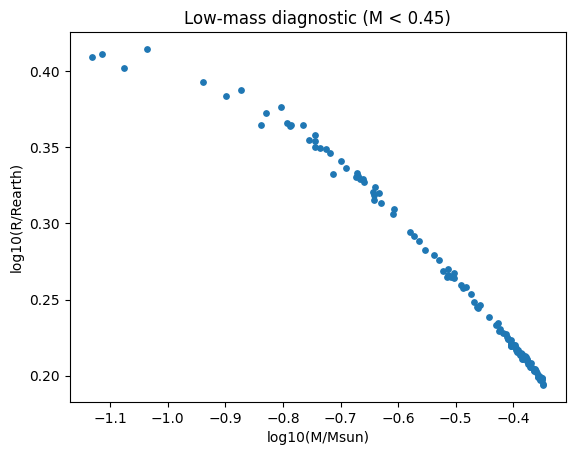

Using N = 128 points


In [88]:
Mmax = 0.45  # Chosen from the Mmax sweep: largest cutoff giving q≈3 with high log-space fit quality and sufficient data points

mask = (M > 0) & (R_cgs > 0) & (M < Mmax)
plt.figure()
plt.scatter(np.log10(M[mask]), np.log10(R_cgs[mask]/R_earth), s=15)
plt.xlabel("log10(M/Msun)")
plt.ylabel("log10(R/Rearth)")
plt.title(f"Low-mass diagnostic (M < {Mmax})")
plt.show()

print("Using N =", mask.sum(), "points")

In [89]:
# quick test for n=1.5 should work
xi1_test, phi1_test, A_test = lane_emden_constants(1.5)
print("n=1.5:", "xi1=", xi1_test, "theta'(xi1)=", phi1_test, "A_n=", A_test)

n=1.5: xi1= 3.6537537362296493 theta'(xi1)= -0.20330128283880675 A_n= 2.714055122797744


In [90]:
def R_of_M_polytrope(M_cgs, n, K):
    """
    Predict radius (cm) for given mass (g) for a Newtonian polytrope:
      P = K rho^{1+1/n}
    Using Lane-Emden constants.
    """
    xi1, phi1, A_n = lane_emden_constants(n)

    # Eq: R = xi1 * [ M / (4π A_n) ]^{(1-n)/(3-n)} * [ (n+1)K/(4πG) ]^{n/(3-n)}
    expoM = (1.0 - n) / (3.0 - n)
    expoK = n / (3.0 - n)

    termM = (M_cgs / (4.0*np.pi*A_n))**expoM
    termK = ((n+1.0)*K / (4.0*np.pi*G))**expoK
    return xi1 * termM * termK

In [91]:
# choose the data used for fit
M_fit = M_cgs[mask]
R_fit = R_cgs[mask]

# Fit q using the generic subset fitter (already defined earlier)
q_best, r2_log, N_fit = fit_q_for_subset(M_fit, R_fit)
n_best = q_best/(5.0-q_best)

# Also compute K_best for that n_best
K_best_float, sse_best = best_K_for_n(n_best, M_fit, R_fit)

print("Fit-1 (q float):")
print("  q_best =", q_best)
print("  n_best =", n_best)
print("  K_best =", K_best_float)
print("  R2(log) =", r2_log, "N =", N_fit)

Fit-1 (q float):
  q_best = 3.006544448968868
  n_best = 1.5082074177243168
  K_best = 2914141380625.3257
  R2(log) = 0.9623924818061362 N = 128


Fit-2 (q fixed integer):
  q_int = 3
  n* = 1.5
  K* = 2792194809105.1196


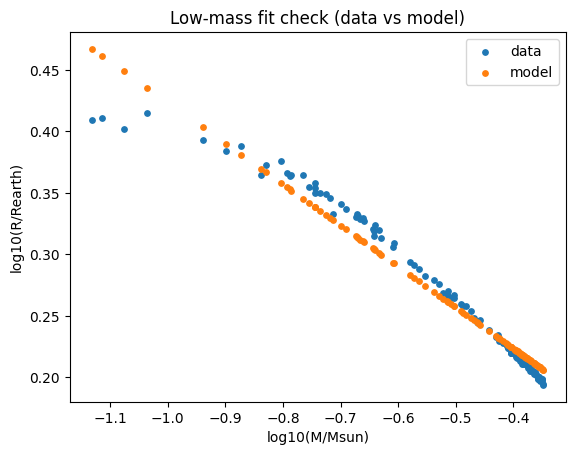

In [92]:
q_int = int(np.round(q_best))
n_star = q_int/(5.0-q_int)

K_star, sse_star = best_K_for_n(n_star, M_fit, R_fit)

print("Fit-2 (q fixed integer):")
print("  q_int =", q_int)
print("  n* =", n_star)
print("  K* =", K_star)

# overlay plot in log-log for sanity
xi1, phi1, A_n = lane_emden_constants(n_star)
expoM = (1.0 - n_star)/(3.0 - n_star)
expoK = n_star/(3.0 - n_star)

# predicted radii for each M_fit using K_star
R_pred = R_of_M_polytrope(M_fit, n_star, K_star)

plt.figure()
plt.scatter(np.log10(M_fit/M_sun), np.log10(R_fit/R_earth), s=15, label="data")
plt.scatter(np.log10(M_fit/M_sun), np.log10(R_pred/R_earth), s=15, label="model")
plt.xlabel("log10(M/Msun)")
plt.ylabel("log10(R/Rearth)")
plt.title("Low-mass fit check (data vs model)")
plt.legend()
plt.show()

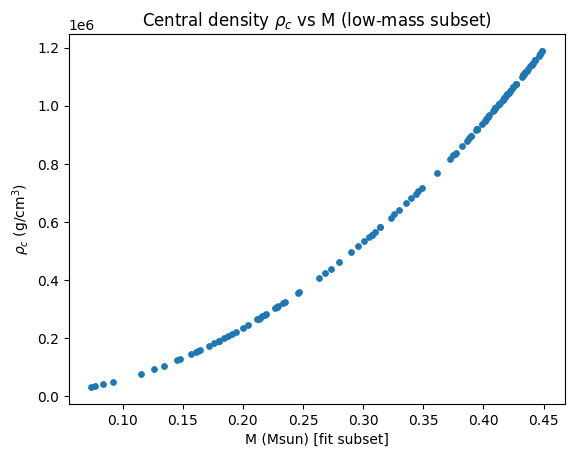

rho_c range: 32287.47334950524 to 1188675.4774897017


In [93]:
def rho_c_from_M(M_cgs, n, K):
    xi1, phi1, A_n = lane_emden_constants(n)
    A = (n+1.0)*K/(4.0*np.pi*G)
    val = (M_cgs/(4.0*np.pi*A_n)) / (A**1.5)
    # rho_c^{(3-n)/(2n)} = val  -> rho_c = val^{2n/(3-n)}
    return val**(2.0*n/(3.0-n))

rho_c = rho_c_from_M(M_fit, n_star, K_star)

plt.figure()
plt.scatter(M_fit/M_sun, rho_c, s=15)
plt.xlabel("M (Msun) [fit subset]")
plt.ylabel(r"$\rho_c$ (g/cm$^3$)")
plt.title(r"Central density $\rho_c$ vs M (low-mass subset)")
plt.show()

print("rho_c range:", rho_c.min(), "to", rho_c.max())

In [94]:
# numerical stability checks

# 1) Lane–Emden constants should be stable vs tolerances
n_test = n_star  # your fitted n*
for rtol in [1e-8, 1e-10, 1e-12]:
    xi1, phi1, A_n = lane_emden_constants(n_test, rtol=rtol, atol=rtol*1e-2)
    print(f"rtol={rtol:1.0e} -> xi1={xi1:.10f}, A_n={A_n:.10f}")

# 2) q_best should not change wildly for nearby Mmax choices (sanity)
for Mmax_try in [0.35, 0.40, 0.45]:
    m = (M > 0) & (R_cgs > 0) & (M < Mmax_try)
    if m.sum() < 8:
        print("Mmax", Mmax_try, "too few points")
        continue
    qb, r2, N = fit_q_for_subset(M_cgs[m], R_cgs[m])
    print(f"Mmax={Mmax_try:.2f} -> q_best={qb:.3f}, R2={r2:.3f}, N={N}")

rtol=1e-08 -> xi1=3.6537537362, A_n=2.7140555314
rtol=1e-10 -> xi1=3.6537537362, A_n=2.7140551228
rtol=1e-12 -> xi1=3.6537537362, A_n=2.7140551201
Mmax=0.35 -> q_best=2.948, R2=0.929, N=59
Mmax=0.40 -> q_best=2.979, R2=0.945, N=76
Mmax=0.45 -> q_best=3.007, R2=0.962, N=128
